In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault
import numpy as np
import pandas as pd

In [2]:
def open_file(name):
    file = open(name, 'r', encoding='utf-8',
                errors='ignore')  # open the file.
    # creat a list that will be full filed with the file with a line as a list element.
    file_list = []
    for line in file:  # open a loop that cover the file.
        line = line.strip('\n')  # drop out all '\n' contained in every line.
        # change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        line = line.split()
        if len(line) == 0:
            file_list.append(' ')
        else:
            file_list.append(line)  # add the line in the list file_list.
    file.close()  # close de file.
    return file_list



In [3]:
def k_path_projwfx(file,n_bnd,atoms):
    def number_identify(string):
        number = ''
        number_list = list(map(lambda x:str(x),range(10)))
        for caracter in string:
            if (caracter in number_list) == True:
                number+=caracter
            elif caracter == '.':
                number+=caracter
            elif caracter == '+':
                old_number = number
                number = ''
        return float(number)

        
    k_value = []; k_tol = 0; i = 0
    for line in file:
        if len(line) >=1:
            if line[0] == 'k':
                if len(k_value)>=1:
                    kx = float(line[2]); ky = float(line[3]); kz = float(line[4])
                    k_mod = np.sqrt((kx-kx_old)**2+(ky-ky_old)**2+(kz_old**2))
                    k_tol+=k_mod
                    k_value.append(round(k_tol,4))
                    del(kx_old);del(ky_old);del(kz_old)
                    kx_old = kx; ky_old = ky; kz_old = kz
                else:
                    kx = float(line[2]); ky = float(line[3]); kz = float(line[4])
                    k_mod = np.sqrt(kx**2+ky**2+kz**2)
                    k_tol+=k_mod
                    k_value.append(round(k_tol,4))
                    kx_old = kx; ky_old = ky; kz_old = kz
        i+=1
    df = pd.DataFrame({'k':k_value})
    band_energy = []
    for j in range(1,n_bnd +1):
        E_orb = []
        for line in file:                                   #open a loop that cover the file.                           #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
            if len(line) >=1:
                if line[0] == '====' and line[2][:-1] == str(j):
                    E_orb.append(float(line[4]))
                 #add the line in the list file_list.
        df['orb '+str(j)] = E_orb
    band_energy.append(np.array(E_orb))

    psi2 = []                                    #creat a list that will be full filed with the file with a line as a list element.
    proj = {}
    for element in atoms:
        proj[element] = []
    for state in atoms:
        proj_band = []
        for j in range(1,n_bnd +1):
            psi_band = []
            proj_temp = []
            for i in range(len(file)):                                   #open a loop that cover the file.                           #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
                line = file[i]
                if len(line) >=1:
                    if line[0] == '====' and line[2][:-1] == str(j):
                        for l in range(i+1,i+20):
                            if j != n_bnd:
                                if file[l][0] == '====':
                                    n = l-1 
                                    break
                            else:
                                if file[l][0] == '====':
                                    n = l-3
                                    break
                                elif file[l][0] == 'Lowdin':
                                    n = l-2
                                    break
                        else:
                            pass
                        #####proj
                        #print(line)
                        proj_psi2_temp2 = []
                        for k in range(i+1,n):
                            for m in range(len(file[k])):
                                item = file[k][m]
                                if item[len(item)-1]== '#':
                                    item2 = file[k][m+1]
                                    number_atom = ''
                                    for o in range(len(item2)):
                                        if item2[o] == ']':
                                            break
                                        else:
                                            number_atom+=item2[o]
                                    if int(number_atom) == state:
                                        if round(float(file[n][2]),2) != 0:
                                            proj_psi2_temp2.append( round(number_identify(item) / float(file[n][2]),2))
                                pass
                        if len(proj_psi2_temp2) == 0:
                            proj_temp.append(0)
                        else:
                            proj_temp.append(proj_psi2_temp2[0])
            proj_band.append(np.array(proj_temp))
        proj[state] = proj_band

    return [df,proj]

In [19]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import interpolate
def teste(axs,x,x_interp,band_energy,band_proj,cmap):
    mini = 99999999999; maxi = 0
    for j in range(1,len(band_proj)):
        band_proj[j] = np.array( band_proj[j] )
        if band_proj[j].max() >= maxi:
            maxi = band_proj[j].max()
        if band_proj[j].min() <= mini:
            mini = band_proj[j].min()
    columns = band_energy.columns
    for i in range(1,len(columns)-1):
        y_int = band_energy[columns[i]]
        #z_int = np.array(band_proj[i]/band_proj[i].sum())
        z_int = np.array(band_proj[i])
        f = interpolate.interp1d(x_interp, y_int)
        g = interpolate.interp1d(x_interp, z_int)
        y = f(x)
        z = g(x)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0,1)
        #norm = plt.Normalize(0, z.max())
        #norm = plt.Normalize(mini,maxi)
        lc = LineCollection(segments, cmap=cmap, norm=norm) #cmap='viridis'
        lc.set_array(z)
        lc.set_linewidth(2)
        line = axs.add_collection(lc)
    axs.set_ylim(-20, 20)
    axs.set_xlim(x.min(),x.max())
    axs.set_facecolor('grey')
    plt.colorbar(line,ax =axs)
    return axs

In [10]:
#name = 'Examples/BN/bands_k/bn.projwfc.out'
name = 'Examples/graphene/bands_proj/projwfc.out'
file = open_file(name)
nbnd= 20
atoms = range(1,9)
bands,bands_k = k_path_projwfx(file,nbnd,atoms)
k = bands['k']
n = 3; list_k_path = [0.]; n_points = 50
for i in range(0,len(k),n_points):
    print(k[i])
    list_k_path.append(k[i])



0.0
0.6667
1.0


In [45]:

#df = pd.read_csv('Examples/graphene/bands_proj/pdos.dat.pdos_atm#1(C)_wfc#1(s)',delim_whitespace=True)
#df = pd.read_csv('Examples/graphene/bands_proj/pdos.dat.pdos_atm#2(C)_wfc#1(s)',delim_whitespace=True)
df = pd.read_csv('Examples/graphene/bands_proj/pdos.dat.pdos_atm#1(C)_wfc#2(p)',delim_whitespace=True)
#df = pd.read_csv('Examples/graphene/bands_proj/pdos.dat.pdos_atm#2(C)_wfc#2(p)',delim_whitespace=True)
#df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_atm#4(N)_wfc#1(s)',delim_whitespace=True)
#df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_atm#2(B)_wfc#1(s)',delim_whitespace=True)
#df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_tot',delim_whitespace=True)
k_tot = df['k']; e_tot = df['E(eV)']; dos_tot = df['ldos(E)']
n = 0
e = []
for i in range(len(k_tot)):
    if k_tot[i] == 1:
        e.append(e_tot[i])
        n+=1


dos = []; K = []; E = []
k_value = bands['k']
for i in range(len(k_value)):
    col = []
    for j in range(n):
        col.append(k_value[i])
    K.append(col)
    E.append(e_tot[i*n:(i+1)*n])
    dos.append(dos_tot[i*n:(i+1)*n])



In [93]:
def States(file):
    states_line = []; atom_number = {}
    for line in file:
        if line[0] == 'state':
            states_line.append(line)
    states = range(1,len(states_line)+1)
    for line in states_line:
        atom_number[int(line[4])] = line[5][1:]

    atom_orb = {}
    for key in atom_number.keys():
        marc_s = False; marc_p = False; marc_d = False
        for line in states_line:
            if int(line[4]) == key:
                if line[8] == '1':
                    if marc_s == False:
                        atom_orb[key] = {'s':[line[2][:1]]}
                        marc_s = True
                    else:
                        atom_orb[key]['s'].append(line[2][:1])
                elif line[8] == '2':
                    if marc_p == False:
                        atom_orb[key].update({'p':[line[2][:1]]})
                        marc_p = True
                    else:
                        atom_orb[key]['p'].append(line[2][:1])
                elif line[8] == '3':
                    if marc_d == False:
                        atom_orb[key].update({'d':[line[2][:1]]})
                        marc_d = True
                    else:
                        atom_orb[key]['d'].append(line[2][:1])
        
    print(atom_orb)
    return [atom_number,atom_orb]
States(file)


{1: {'s': ['1'], 'p': ['2', '3', '4']}, 2: {'s': ['5'], 'p': ['6', '7', '8']}}


[{1: 'C', 2: 'C'},
 {1: {'s': ['1'], 'p': ['2', '3', '4']},
  2: {'s': ['5'], 'p': ['6', '7', '8']}}]

In [94]:
for keys in States(file)[1][1].keys():
    print(keys)

{1: {'s': ['1'], 'p': ['2', '3', '4']}, 2: {'s': ['5'], 'p': ['6', '7', '8']}}
s
p


(-8.0, 8.0)

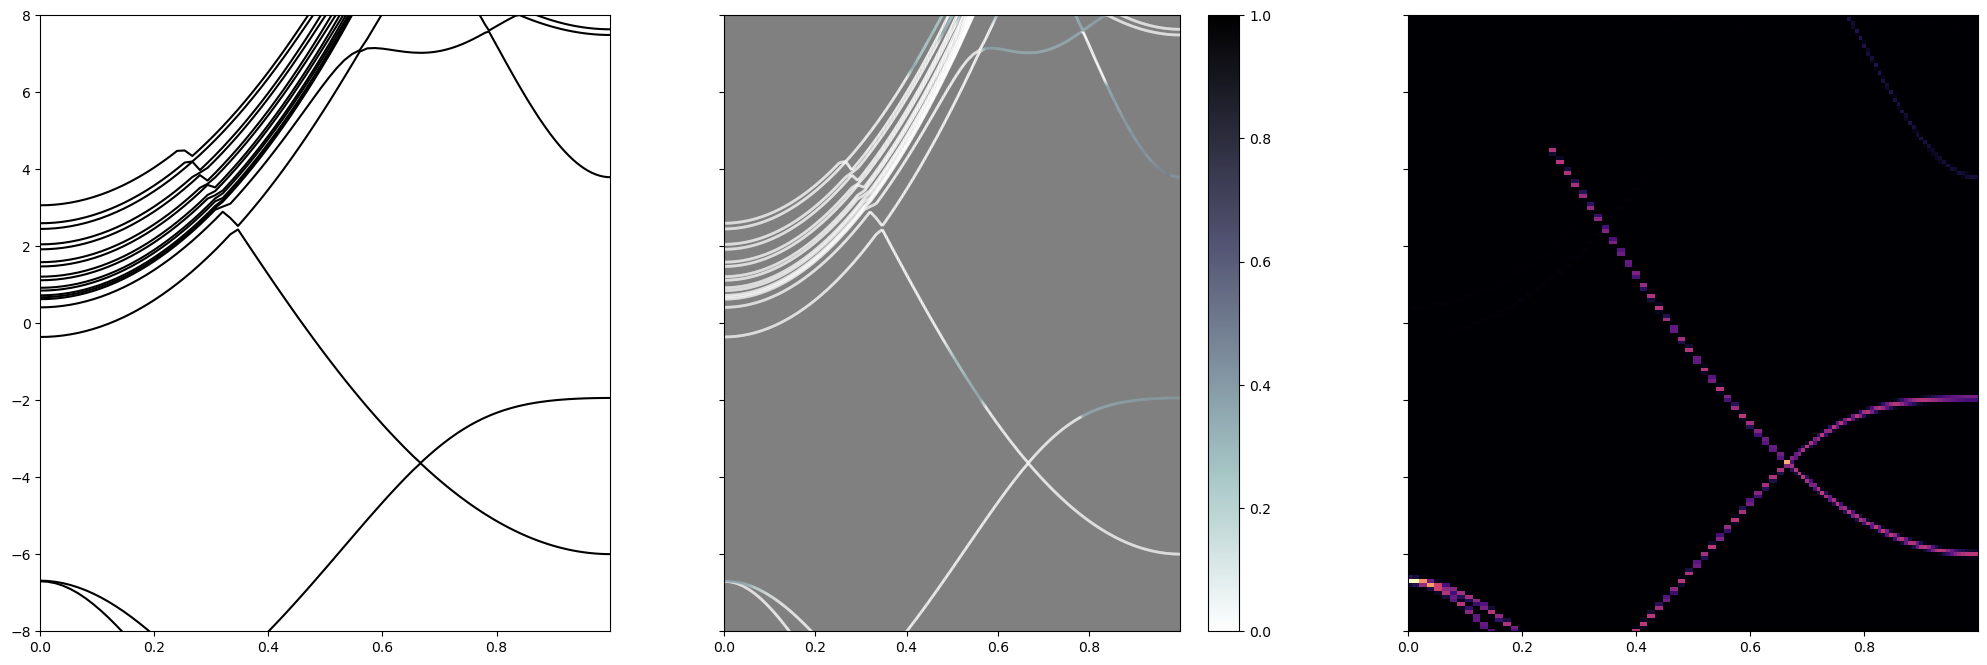

In [46]:
fig,figura = plt.subplots(1,3,sharex=True, sharey=True,figsize = (25,8))

k = bands['k']
coluns = bands.columns
for i in range(1,len(coluns)):
    E2= bands[coluns[i]]
    figura[0].plot(k,E2,color = 'black')

x = np.arange(0,k.max(),0.001)
teste(figura[1],x,k,bands,bands_k[1],'bone_r')

figura[2].pcolormesh(K,E,dos, cmap='magma', shading='auto')
figura[2].set_ylim(-8,8)
#plt.colorbar(figura[2])

In [228]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import interpolate
def teste(axs,x,x_interp,band_energy,band_proj,cmap):
    mini = 99999999999; maxi = 0
    for j in range(1,len(band_proj)):
        band_proj[j] = np.array( band_proj[j] )
        if band_proj[j].max() >= maxi:
            maxi = band_proj[j].max()
        if band_proj[j].min() <= mini:
            mini = band_proj[j].min()
    columns = band_energy.columns
    for i in range(1,len(columns)-1):
        y_int = band_energy[columns[i]]
        #z_int = np.array(band_proj[i]/band_proj[i].sum())
        z_int = np.array(band_proj[i])
        f = interpolate.interp1d(x_interp, y_int)
        g = interpolate.interp1d(x_interp, z_int)
        y = f(x)
        z = g(x)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0,1)
        #norm = plt.Normalize(0, z.max())
        #norm = plt.Normalize(mini,maxi)
        lc = LineCollection(segments, cmap=cmap, norm=norm) #cmap='viridis'
        lc.set_array(z)
        lc.set_linewidth(2)
        line = axs.add_collection(lc)
    axs.set_ylim(-20, 20)
    axs.set_xlim(x.min(),x.max())
    axs.set_facecolor('grey')
    fig.colorbar(line,ax =axs)
    return axs

def teste2(axs,x,x_interp,band_energy,band_proj,band_proj_2,cmap):
    mini = 99999999999; maxi = 0
    for j in range(1,len(band_proj)):
        band_proj[j] = np.array( band_proj[j] )
        if band_proj[j].max() >= maxi:
            maxi = band_proj[j].max()
        if band_proj[j].min() <= mini:
            mini = band_proj[j].min()
    columns = band_energy.columns
    for i in range(1,len(columns)-1):
        y_int = band_energy[columns[i]]
        z_int = np.array(band_proj[i]/band_proj[i].sum())
        #z_int = np.array(band_proj[i])
        f = interpolate.interp1d(x_interp, y_int)
        g = interpolate.interp1d(x_interp, z_int)
        y = f(x)
        z = g(x)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0,1)
        #norm = plt.Normalize(0, z.max())
        #norm = plt.Normalize(mini,maxi)
        lc = LineCollection(segments, cmap=cmap, norm=norm) #cmap='viridis'
        lc.set_array(z)
        lc.set_linewidth(2)
        line = axs.add_collection(lc)
    axs.set_ylim(-20, 20)
    axs.set_xlim(x.min(),x.max())
    axs.set_facecolor('grey')
    fig.colorbar(line,ax =axs)
    return axs
from scipy.integrate import quad

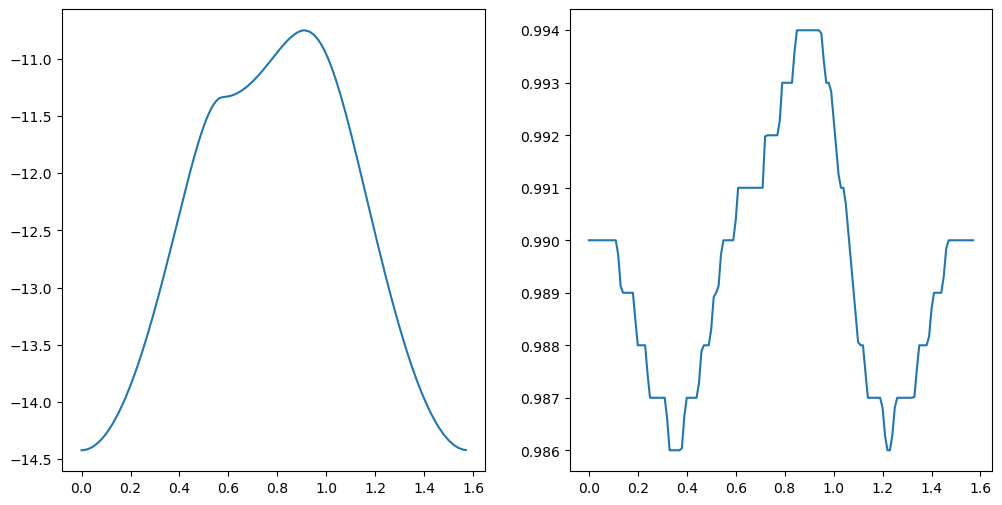

In [189]:
fig, figura = plt.subplots(1,2,figsize = (12,6))

i = 0
x = np.arange(k.min(),k.max(),0.01)
f = interpolate.interp1d(k,bands[bands.columns[i+1]])

figura[0].plot(x,f(x))

g = interpolate.interp1d(k,proj[i])

figura[1].plot(x,g(x))

#print(quad(g, 0 , k.max()))

In [173]:
per_atom = {'B': [], 'N' : []}
for i in range(17):
    if i == 0:
        list_nbnd = []
        for j in range(nbnd):
            lista = bands_k[i][j]
            list_nbnd.append(lista)
        list_nbnd = np.array(list_nbnd)
len(list_nbnd[0])

IndexError: list index out of range

In [172]:
nbnd = 18
per_atom = {'B': [], 'N' : []}
for i in range(15):
    if i==0:
        per_atom['B'] = np.array(bands_k[i]) 
    elif i>=1 and i<8:
        per_atom['B'] = per_atom['B'] + bands_k[i] 
    elif i==8:
        per_atom['N'] = np.array(bands_k[i]) 
    elif i>=9 and i<15:
        per_atom['N'] = per_atom['N'] + bands_k[i] 


In [186]:
nbnd = 18
per_atom_p = {'B_s': [], 'N_s' : []}
for i in range(16):
    if i==0:
        per_atom['B_s'] = np.array(bands_k[i]) 
    elif i>1 and i<4:
        per_atom['B_s'] = per_atom['B_s'] + bands_k[i] 
    elif i==9:
        per_atom['N_s'] = np.array(bands_k[i]) 
    elif i>9 and i<12:
        per_atom['N_s'] = per_atom['N_s'] + bands_k[i] 

In [187]:
nbnd = 18
per_atom_p = {'B_p': [], 'N_p' : []}
for i in range(16):
    if i==1:
        per_atom['B_p'] = np.array(bands_k[i]) 
    elif i>1 and i<4:
        per_atom['B_p'] = per_atom['B_p'] + bands_k[i] 
    elif i==13:
        per_atom['N_p'] = np.array(bands_k[i]) 
    elif i>13 and i<=15:
        per_atom['N_p'] = per_atom['N_p'] + bands_k[i] 

In [109]:
n = 4; list_k_path = [0.]; n_points = 35
for i in range(0,len(k),n_points):
    print(k[i])
    list_k_path.append(k[i])

0.0
0.5774
0.9107
1.5774


<AxesSubplot:>

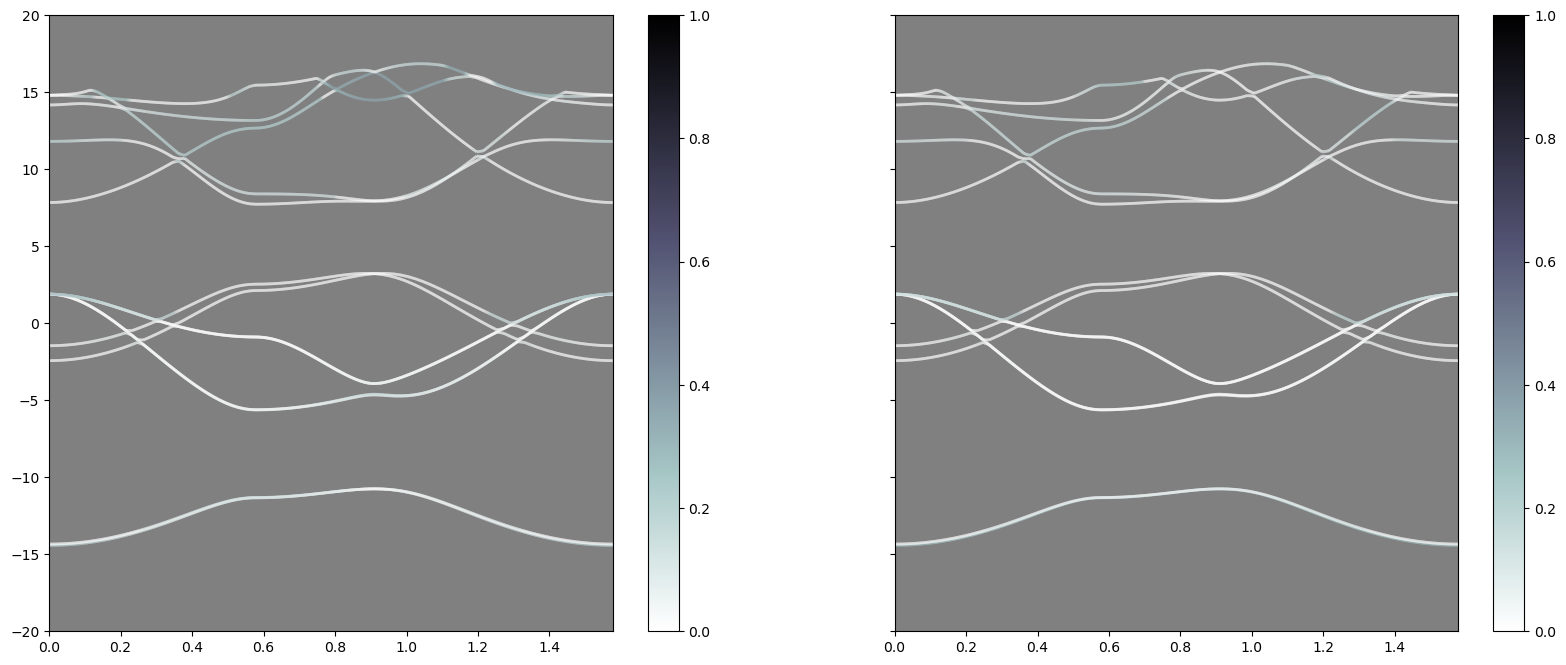

In [229]:

x = np.arange(0,k.max(),0.001)
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize = (20,8))
teste(axs[0],x,k,bands,bands_k[1],'bone_r')

teste(axs[1],x,k,bands,bands_k[9],'bone_r')


#teste(axs[1][0],x,k,bands,per_atom['B_p'],'bone_r')

#teste(axs[1][1],x,k,bands,per_atom['N_p'],'bone_r')

In [6]:
file = open('Examples/Si-fcc/band_kpdos/si.projwfc.out')
FILE = []
k_value = []                                      #creat a list that will be full filed with the file with a line as a list element.
k_tol = 0
i = 0
for line in file:                                   #open a loop that cover the file.
    line = line.strip('\n')                         #drop out all '\n' contained in every line.
    line = line.split()                             #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
    if len(line) >=1:
        if line[0] == 'k':
            if len(k_value)>=1:
                kx = float(line[2]); ky = float(line[3]); kz = float(line[4])
                k_mod = np.sqrt((kx-kx_old)**2+(ky-ky_old)**2+(kz_old**2))
                k_tol+=k_mod
                k_value.append(round(k_tol,4))
                del(kx_old);del(ky_old);del(kz_old)
                kx_old = kx; ky_old = ky; kz_old = kz
            else:
                kx = float(line[2]); ky = float(line[3]); kz = float(line[4])
                k_mod = np.sqrt(kx**2+ky**2+kz**2)
                k_tol+=k_mod
                k_value.append(round(k_tol,4))
                kx_old = kx; ky_old = ky; kz_old = kz
           #add the line in the list file_list.
    FILE.append(line)
    i+=1
file.close()   

df = pd.DataFrame({'k':k_value})
df

,k
0,0.0000
1,0.0500
2,0.1000
3,0.1500
4,0.2000
...,...
196,33.0441
197,33.0956
198,33.1351
199,33.1631


In [106]:
                                   #creat a list that will be full filed with the file with a line as a list element.
k_tol = 0
n_bnd =20
band_energy = []
for j in range(1,n_bnd +1):
    E_orb = []
    for line in FILE:                                   #open a loop that cover the file.                           #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        if len(line) >=1:
            if line[0] == '====' and line[2][:-1] == str(j):
                E_orb.append(float(line[4]))
                 #add the line in the list file_list.
    df['orb '+str(j)] = E_orb
    band_energy.append(np.array(E_orb))
df



,k,orb 1,orb 2,orb 3,orb 4,orb 5,orb 6,orb 7,orb 8,orb 9,...,orb 11,orb 12,orb 13,orb 14,orb 15,orb 16,orb 17,orb 18,orb 19,orb 20
0,0.0000,-23.15931,-11.25003,-6.70244,-6.68459,-0.35591,0.41331,0.62582,0.67546,0.72561,...,0.92183,1.11719,1.21004,1.47557,1.58669,1.92045,2.04968,2.45028,2.59773,3.06434
1,0.0133,-23.15617,-11.24626,-6.71438,-6.69279,-0.35164,0.41765,0.63021,0.67984,0.73000,...,0.92622,1.12158,1.21442,1.47995,1.59107,1.92483,2.05406,2.45465,2.60210,3.06871
2,0.0267,-23.14674,-11.23495,-6.75202,-6.71529,-0.33883,0.43065,0.64339,0.69301,0.74317,...,0.93938,1.13472,1.22757,1.49309,1.60421,1.93796,2.06718,2.46777,2.61521,3.08182
3,0.0400,-23.13102,-11.21610,-6.81579,-6.75082,-0.31748,0.45233,0.66535,0.71496,0.76512,...,0.96132,1.15664,1.24949,1.51499,1.62611,1.95984,2.08906,2.48964,2.63705,3.10367
4,0.0533,-23.10902,-11.18973,-6.90416,-6.79956,-0.28759,0.48267,0.69609,0.74569,0.79585,...,0.99203,1.18732,1.28018,1.54565,1.65677,1.99047,2.11968,2.52025,2.66764,3.13425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.9733,-17.91844,-16.87508,-10.14099,-5.98069,-1.94332,3.86960,7.50280,7.65137,8.31940,...,8.87813,8.87830,8.91930,8.92406,8.97334,8.97471,9.07458,9.09022,9.16167,9.16504
97,0.9800,-17.92316,-16.87975,-10.11635,-5.98741,-1.94168,3.83624,7.49633,7.64447,8.31878,...,8.87045,8.87061,8.91173,8.91637,8.96567,8.96704,9.06728,9.08254,9.15403,9.15738
98,0.9867,-17.92652,-16.88309,-10.09866,-5.99221,-1.94051,3.81232,7.49171,7.63954,8.31827,...,8.86496,8.86512,8.90631,8.91089,8.96020,8.96156,9.06206,9.07705,9.14857,9.15192
99,0.9933,-17.92854,-16.88510,-10.08801,-5.99510,-1.93982,3.79793,7.48893,7.63659,8.31794,...,8.86167,8.86183,8.90307,8.90759,8.95691,8.95827,9.05892,9.07376,9.14530,9.14864


In [110]:
psi2 = []                                    #creat a list that will be full filed with the file with a line as a list element.
k_tol = 0
n_bnd =14
file = open_file(name)
for j in range(1,n_bnd +1):
    psi_band = []
    i =0
    for l in range(len(file)):                                   #open a loop that cover the file.                           #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        line = file[l]
        if len(line) >=1 :
            if line[0] == '====' and line[2][:-1] == str(j):
                if file[l+2][0] == '|psi|^2':
                    psi_band.append(float(file[l+2][2]))
                elif file[l+3][0] == '|psi|^2':
                    psi_band.append(float(file[i+3][2]))
                elif file[i+4][0] == '|psi|^2':
                    psi_band.append(float(file[i+4][2]))
                elif file[i+5][0] == '|psi|^2':
                    psi_band.append(float(file[i+5][2]))

        i+=1
    print(len(psi_band))
    psi2.append(np.array(psi_band))
psi2 = np.array(psi2)
psi2


149
149
149
149
149
149
149
149
149
149
149
149
148
148


/tmp/ipykernel_8500/2128060574.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  psi2 = np.array(psi2)


array([array([0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 ,
              0.989, 0.989, 0.989, 0.989, 0.988, 0.988, 0.988, 0.988, 0.987,
              0.987, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987,
              0.988, 0.988, 0.989, 0.989, 0.99 , 0.99 , 0.99 , 0.991, 0.991,
              0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991,
              0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.993,
              0.993, 0.993, 0.993, 0.993, 0.993, 0.994, 0.994, 0.994, 0.994,
              0.994, 0.994, 0.994, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995,
              0.994, 0.994, 0.993, 0.993, 0.992, 0.991, 0.99 , 0.99 , 0.989,
              0.988, 0.988, 0.988, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987,
              0.987, 0.988, 0.988, 0.988, 0.988, 0.989, 0.989, 0.989, 0.99 ,
              0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 ,
              0.99 , 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991,

In [277]:
def number_identify(string):
        number = ''
        number_list = list(map(lambda x:str(x),range(10)))
        for caracter in string:
            if (caracter in number_list) == True:
                number+=caracter
            elif caracter == '.':
                number+=caracter
            elif caracter == '+':
                old_number = number
                number = ''
        return float(number)



n_bnd =20
count = []
for j in range(1,n_bnd +1):
    i =0
    count_temp = []
    for line in FILE:                                   #open a loop that cover the file.                           #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        if len(line) >=1:
            if line[0] == '====' and line[2][:-1] == str(j):
                count_temp.append(i)
        i+=1
    count.append(count_temp)


print(count[0][0])
print(count[1][0])

69
72


In [286]:


n_bnd = 20
atoms = [1,2,3,4,5,6,7,8]
proj_atoms = {}
for h in range(len(atoms)):
    proj_psi2 = []
    for i in range(n_bnd):
        proj_psi2_temp = []
        for j in range(len(count[i])):
            if i < n_bnd-1:
                l = count[i][j]
                l2 = count[i+1][j]
                n = l2-l
            else:
                n=2
            marker = False
            for k in range(l+1,l+n-1):
                #print(FILE[l])
                line = FILE[k]
                if len(line) >0:
                    if line[0] == 'psi':
                        #print(line)
                        for m in range(2,len(line)-1):
                            item = line[m]
                            if item[len(item)-1] == '#':
                                if line[m+1][0] == str(atoms[h]):
                                    proj_psi2_temp2= number_identify(item)
                                    marker = True
            if marker == False:
                proj_psi2_temp.append(0)
            else:
                proj_psi2_temp.append(proj_psi2_temp2)
                #else:
                    #proj_psi2_temp.append(0)
            #if len(proj_psi2_temp) == 0:
                #proj_psi2_temp.append(0)
            #print(proj_psi2_temp)
            #print('----')
        proj_psi2_temp = np.array(proj_psi2_temp)
        proj_psi2.append(proj_psi2_temp)
    proj_psi2 = np.array(proj_psi2)
    proj_atoms[atoms[h]] = proj_psi2
    
proj_atoms[1]

array([[0.492, 0.492, 0.49 , ..., 0.312, 0.312, 0.312],
       [0.   , 0.   , 0.   , ..., 0.105, 0.105, 0.105],
       [0.   , 0.   , 0.001, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

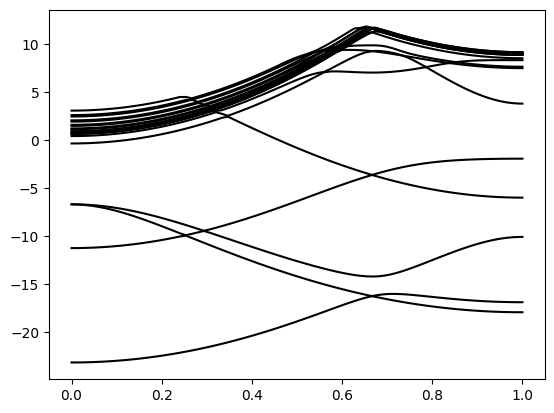

In [108]:
fig,figura = plt.subplots()
k = df['k']
coluna = df.columns
for i in range(1,len(coluna)):
    energy = df[coluna[i]]
    figura.plot(k,energy,c= 'black')

In [306]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import interpolate
def teste(axs,x,x_interp,band_energy,band_proj,zmax,zmin):
    for i in range(1,n_bnd):
        y_int = band_energy[i]
        z_int = np.array(band_proj[i]/band_proj[i].sum())
        #z_int = np.array(band_proj[i])
        f = interpolate.interp1d(x_interp, y_int)
        g = interpolate.interp1d(x_interp, z_int)
        y = f(x)
        z = g(x)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(z.min(), z.max())
        lc = LineCollection(segments, cmap='viridis', norm=norm) #cmap='viridis'
        lc.set_array(z)
        lc.set_linewidth(2)
        line = axs.add_collection(lc)
    axs.set_ylim(-20, 10)
    axs.set_facecolor('grey')
    fig.colorbar(line)
    return axs


<AxesSubplot: >

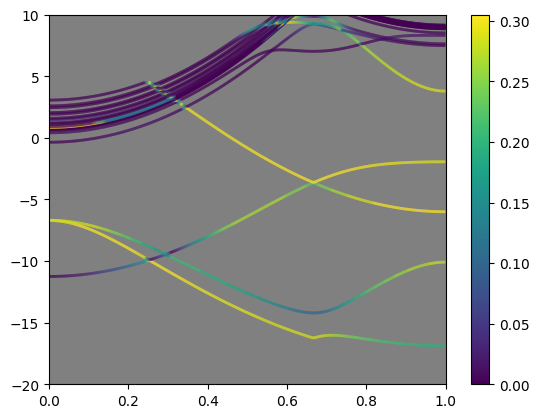

In [307]:
x = np.arange(0,df['k'].max(),0.001)
fig, axs = plt.subplots(sharex=True, sharey=True)
teste(axs,x,df['k'],band_energy,psi2,psi2.max(),psi2.min())


/tmp/ipykernel_3230/41328881.py:7: RuntimeWarning: invalid value encountered in divide
  z_int = np.array(band_proj[i]/band_proj[i].sum())


<AxesSubplot: >

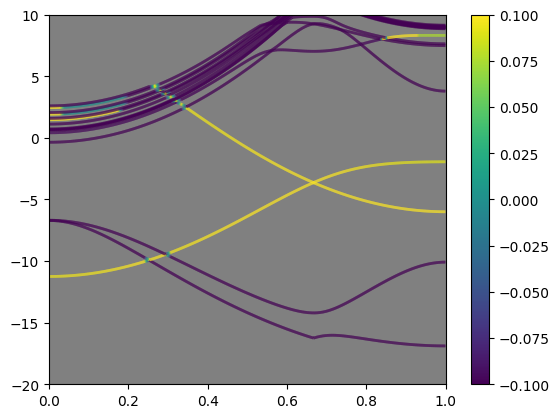

In [308]:
x = np.arange(0,df['k'].max(),0.001)
fig, axs = plt.subplots(sharex=True, sharey=True)
key = 6
proj = proj_atoms[key]
teste(axs,x,df['k'],band_energy,proj,psi2.max(),psi2.min())

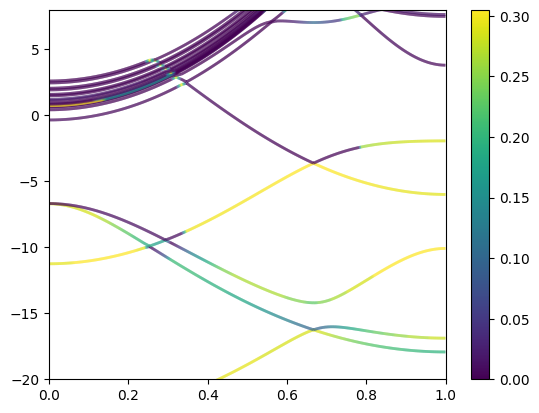

In [99]:


x_int = df['k']

fig, axs = plt.subplots(sharex=True, sharey=True)
for i in range(1,n_bnd):
    columns = df.columns
    y_int = df[columns[i]]
    z_int = np.array(psi2[i]/psi2[i].sum())
    f = interpolate.interp1d(x_int, y_int)
    g = interpolate.interp1d(x_int, z_int)
    y = f(x)
    z = g(x)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(z.min(), z.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_ylim(-20, 8)
fig.colorbar(line)

In [26]:

df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_atm#4(N)_wfc#1(s)',delim_whitespace=True)
#df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_atm#2(B)_wfc#1(s)',delim_whitespace=True)
#df = pd.read_csv('Examples/BN/bands_k/bn.pdos.dat.pdos_tot',delim_whitespace=True)
k_tot = df['k']; e_tot = df['E(eV)']; dos_tot = df['ldos(E)']
n = 0
e = []
for i in range(len(k_tot)):
    if k_tot[i] == 1:
        e.append(e_tot[i])
        n+=1


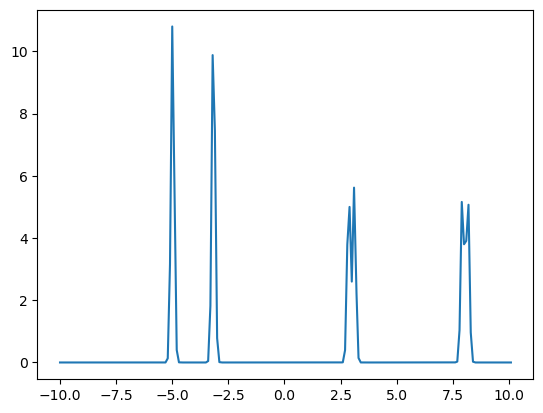

In [28]:
i=60
e_ip = e_tot[i*n:(i+1)*n]
dos_ip =dos_tot[i*n:(i+1)*n]
E = np.arange(e_tot.min(),e_tot.max(),0.01)
dos = np.interp(E,e_ip,dos_ip)
plt.plot(E,dos)

In [27]:
dos = []; K = []; E = []
k_value = k
for i in range(len(k_value)):
    col = []
    for j in range(n):
        col.append(k_value[i])
    K.append(col)
    E.append(e_tot[i*n:(i+1)*n])
    dos.append(dos_tot[i*n:(i+1)*n])

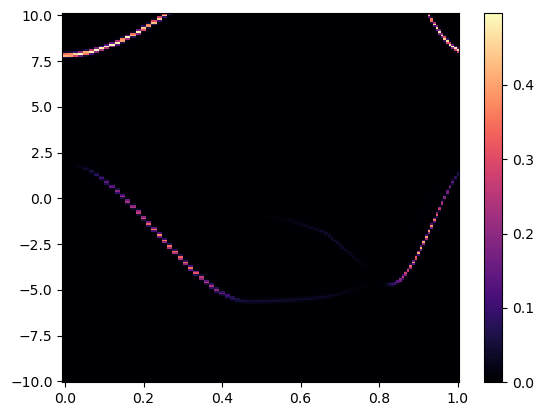

In [28]:

plt.pcolormesh(K,E,dos, cmap='magma', shading='auto')
plt.colorbar()